In [373]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt
from tqdm import trange

In [382]:
colors = np.array(
         [[0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.5],
          [0.125, 0.529, 1.0],
          [0.33, 0.4, 0.67],
          [0.6, 0.5, 1.0],
          [0., 1., 0.],
          [1., 0., 0.],
          [0., 1., 1.],
          [1., 0., 1.],
          [1., 1., 0.],
          [1., 1., 1.],
          [.33, .33, .33],
          [.5, .5, .5],
          [.66, .66, .66]])

# store the names of the colors for visualization later on
color_names = \
        ['black', 'blue', 'darkblue', 'skyblue',
         'greyblue', 'lilac', 'green', 'red',
         'cyan', 'violet', 'yellow', 'white',
         'darkgrey', 'mediumgrey', 'lightgrey']

In [ ]:
class SOM():
    '''
        Optimized version: distance-map precomputed
    '''
    def __init__(self, shape):
        self.h, self.w = shape
        self.r = min(self.h, self.w)
        self.r_decay = 0.99
        self.lr = 0.1
        self.lr_decay = 0.999
        self.K = None
    def train(self, data, iterations = 100, boundary='periodic'):
        if self.K is None:
            self.d = data.shape[1]
            self.K = np.random.randn(self.h,self.w,self.d)
        # create dist maps in advance
        if boundary == 'periodic':
            dist_map = np.array([[sqrt((i-self.w//2)**2 + (j-self.h//2)**2) for i in range(self.w)] for j in range(self.h)])
        else:
            dist_map = np.array([[sqrt(i**2 + j**2) for i in range(-self.w,self.w)] for j in range(-self.h,self.h)])
        for _ in trange(iterations):
            for j in np.random.permutation(data.shape[0]):
                datum = data[j, :]
                diff = datum - self.K
                self.d = (diff**2).sum(axis=-1)
                d_min = np.argmin(self.d)
                d_min_x  = d_min % self.w
                d_min_y = d_min // self.w
                if boundary == 'periodic':
                    d_map = np.roll(np.roll(dist_map, d_min_x - (self.w//2),axis=1), d_min_y - (self.h//2),axis=0)
                else:
                    d_map = dist_map[self.h-d_min_y:2*self.h-d_min_y, self.w-d_min_x:2*self.w-d_min_x]
                mask = np.exp(-d_map**2/self.r)
                mask[d_map > self.r] = 0
                self.K += self.lr * mask[:,:,np.newaxis] * diff
            self.r *= self.r_decay
            self.lr *= self.lr_decay
    def __call__(self, data):
        out = []
        for j in range(data.shape[0]):
            datum = data[j, :]
            diff = datum - self.K
            self.d = (diff**2).sum(axis=-1)
            d_min = np.argmin(self.d)
            out.append((d_min % self.w, d_min // self.w))
        return out
    

In [688]:
class SOM():
    '''
        TODO: implement toroidal boundary conditions
    '''
    def __init__(self, shape):
        self.h, self.w = shape
        self.r = min(self.h, self.w)
        self.r_decay = 0.99
        self.lr = 0.1
        self.lr_decay = 0.999
        self.K = None
    def train(self, data, iterations = 100, boundary='periodic'):
        if self.K is None:
            self.d = data.shape[1]
            #self.K = np.random.randn(self.h,self.w,self.d)
            self.K = np.random.random((self.h,self.w,self.d))
        for _ in trange(iterations):
            for j in np.random.permutation(data.shape[0]):
                datum = data[j, :]
                diff = datum - self.K
                self.d = (diff**2).sum(axis=-1)
                d_min = np.argmin(self.d)
                d_min_x  = d_min % self.w
                d_min_y = d_min // self.w
                if boundary == 'periodic':
                    # periodic boundary conditions
                    dist_map = np.array([[sqrt((i-self.w//2)**2 + (j-self.h//2)**2) for i in range(self.w)] for j in range(self.h)])
                    dist_map = np.roll(np.roll(dist_map, d_min_x - (self.w//2),axis=1), d_min_y - (self.h//2),axis=0)
                else:
                    dist_map = np.array([[sqrt((i - d_min_x)**2 + (j-d_min_y)**2) for i in range(self.w)] for j in range(self.h)])
                
                mask = np.exp(-dist_map**2/self.r)
                mask[dist_map > self.r] = 0
                self.K += self.lr * mask[:,:,np.newaxis] * diff
            self.r *= self.r_decay
            self.lr *= self.lr_decay
    def __call__(self, data):
        out = []
        for j in range(data.shape[0]):
            datum = data[j, :]
            diff = datum - self.K
            self.d = (diff**2).sum(axis=-1)
            d_min = np.argmin(self.d)
            out.append((d_min % self.w, d_min // self.w))
        return out
    

100%|██████████| 3000/3000 [00:27<00:00, 110.00it/s]


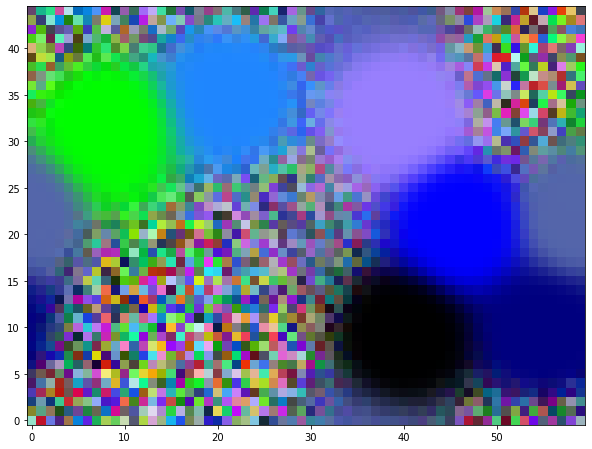

In [692]:
som = SOM((45,60))
som.train(colors, 3000)
som.K.shape
plt.imshow(som.K,origin='lower')

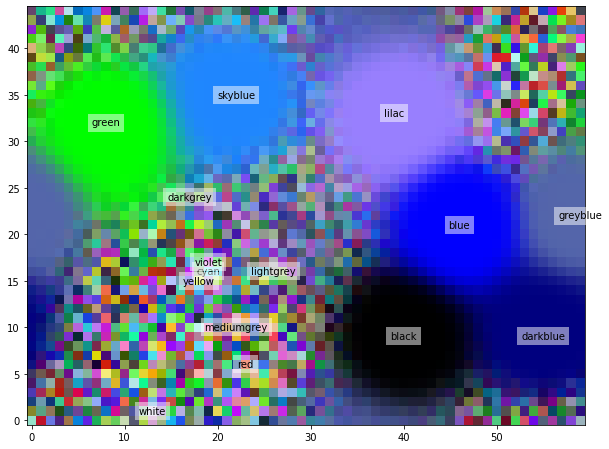

In [693]:
pts = som(colors)
plt.rcParams['figure.figsize'] = (10,9)
plt.imshow(som.K, origin='lower', interpolation='nearest')
for i, pt in enumerate(pts):
    plt.text(pt[0], pt[1], color_names[i], va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

In [611]:
data = np.vstack((np.random.randn(5,2)*0.3+[6, 2], np.random.randn(5,2)*0.3+[0, 2], np.random.randn(5,2)*0.3+[3, -1]))
c = np.array([0]*5+[1]*5+[2]*5)
c

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [612]:
som = SOM((20,30))
som.train(data, 1000, 'nonperiodic')
som.K.shape


100%|██████████| 1000/1000 [00:04<00:00, 217.81it/s]


(20, 30, 2)

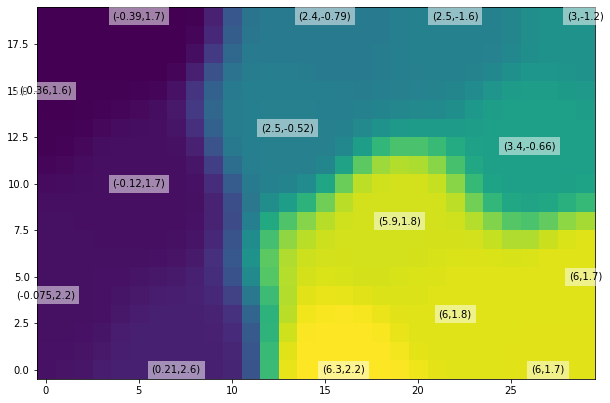

In [613]:
plt.imshow(som.K[:,:,0],origin='lower')
pts = som(data)
for i, pt in enumerate(pts):
    plt.text(pt[0], pt[1], f'({data[i, 0]:1.2g},{data[i, 1]:1.2g})', va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

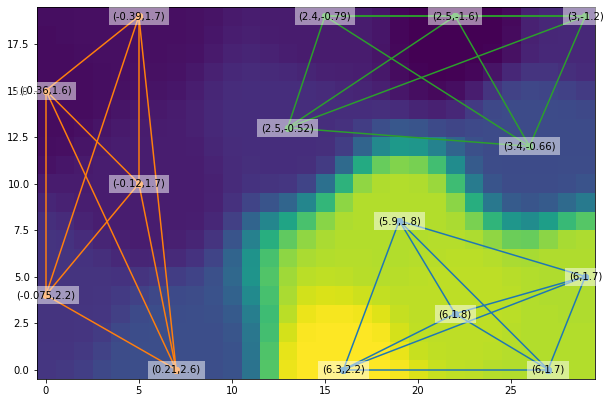

In [618]:
plt.imshow(som.K.mean(axis=2),origin='lower')
inds = np.arange(len(pts))
for j in range(3):
    ind = c == j
    indx = inds[ind]
    for k in range(len(indx)-1):
        for l in range(k+1, len(indx)):
            plt.plot([pts[indx[k]][0],pts[indx[l]][0]], [pts[indx[k]][1],pts[indx[l]][1]],'o-', c=f'C{j}')
for i, pt in enumerate(pts):
    plt.text(pt[0], pt[1], f'({data[i, 0]:1.2g},{data[i, 1]:1.2g})', va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

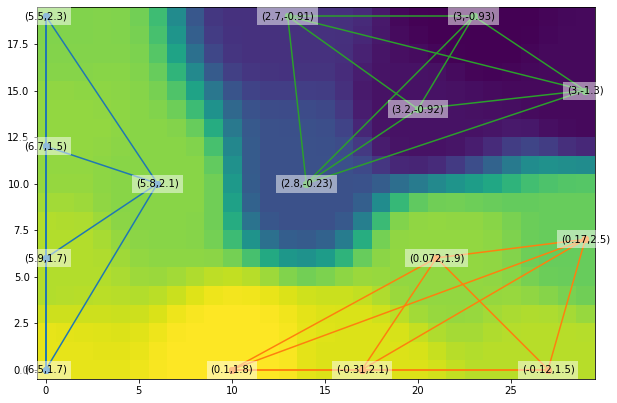

In [499]:
plt.imshow(som.K[:,:,1],origin='lower')
inds = np.arange(len(pts))
for j in range(3):
    ind = c == j
    indx = inds[ind]
    for k in range(len(indx)-1):
        for l in range(k+1, len(indx)):
            plt.plot([pts[indx[k]][0],pts[indx[l]][0]], [pts[indx[k]][1],pts[indx[l]][1]],'o-', c=f'C{j}')
for i, pt in enumerate(pts):
    plt.text(pt[0], pt[1], f'({data[i, 0]:1.2g},{data[i, 1]:1.2g})', va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

In [619]:
tmp = np.loadtxt('rbdnc440.txt')
data = tmp[1:225,1:]
c = tmp[0, 1:]
z = tmp[1:225, 0]

In [620]:
data = (data  - np.min(data))/(np.max(data)-np.min(data))

In [636]:
som = SOM((50,50))
som.train(data.T, 200, 'nonperiodic')
som.K.shape

100%|██████████| 200/200 [11:15<00:00,  3.38s/it]


(50, 50, 224)

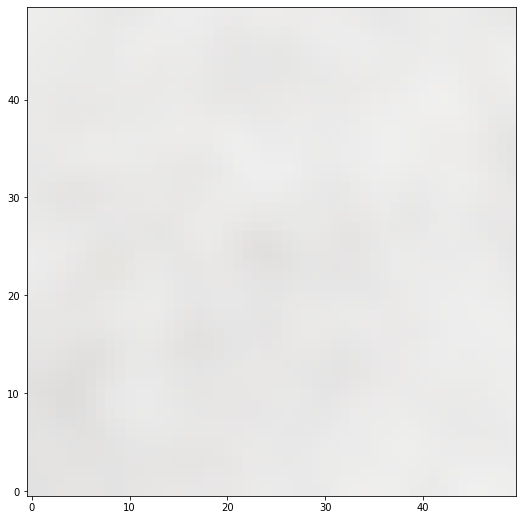

In [638]:
plt.imshow(som.K[:,:,:3],origin='lower')

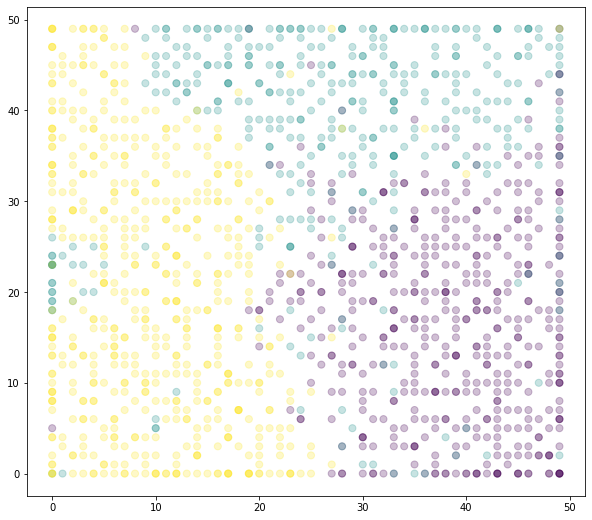

In [643]:
pts = som(data.T)
pts_ = np.array(pts)
plt.imshow(som.K.sum(axis=2),origin='lower',cmap='inferno')
plt.scatter(pts_[:,0], pts_[:,1], c=c, alpha=0.25,s=50,cmap='viridis')

## SOM on iris 

In [670]:
from sklearn.datasets import load_iris
iris = load_iris()
data = iris['data']
c = iris['target']
data = (data - data.min())/(data.max()-data.min())

In [671]:
som = SOM((30,30))

In [672]:
som.train(data, 1000, 'nonperiodic')

100%|██████████| 1000/1000 [01:06<00:00, 14.93it/s]


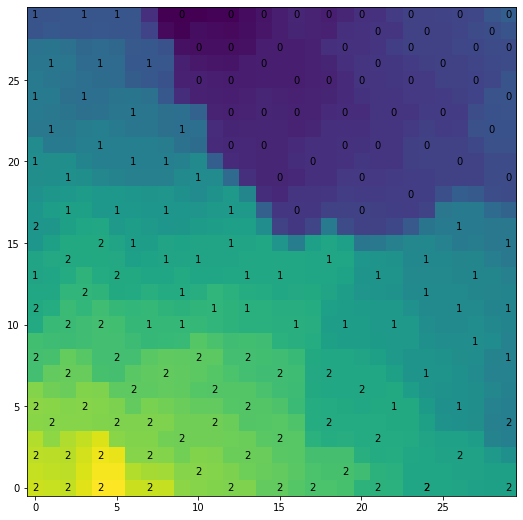

In [673]:
pts = som(data)
pts_ = np.array(pts)
plt.imshow(som.K.sum(axis=2),origin='lower')
#plt.scatter(pts_[:,0], pts_[:,1], c=c, alpha=0.25,s=50,cmap='viridis')
for i in range(len(pts)):
    plt.text(pts_[i,0], pts_[i,1],c[i], va='center',ha='center')

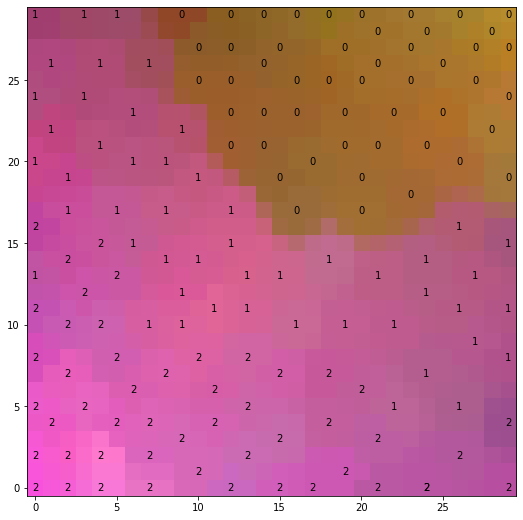

In [679]:
plt.imshow(som.K[:,:,:3],origin='lower')
#plt.scatter(pts_[:,0], pts_[:,1], c=c, alpha=0.25,s=50,cmap='viridis')
for i in range(len(pts)):
    plt.text(pts_[i,0], pts_[i,1],c[i], va='center',ha='center')

In [681]:
# test on https://github.com/JustGlowing/minisom
data = np.array([[ 0.80,  0.55,  0.22,  0.03],
        [ 0.82,  0.50,  0.23,  0.03],
        [ 0.80,  0.54,  0.22,  0.03],
        [ 0.80,  0.53,  0.26,  0.03],
        [ 0.79,  0.56,  0.22,  0.03],
        [ 0.75,  0.60,  0.25,  0.03],
        [ 0.77,  0.59,  0.22,  0.03]]      )

In [682]:
som = SOM((7,7))

In [684]:
som.train(data,1000)

100%|██████████| 1000/1000 [00:00<00:00, 1926.38it/s]


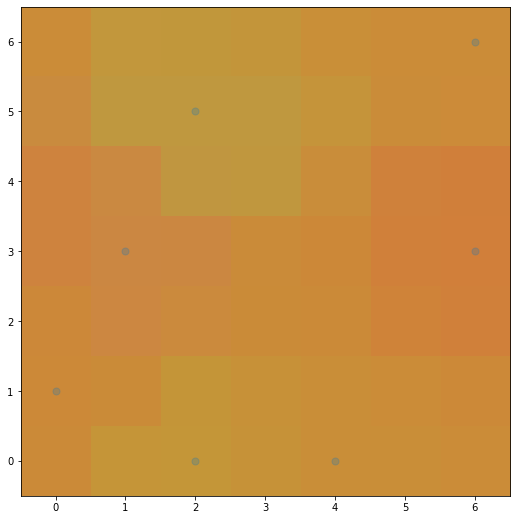

In [687]:
pts = som(data)
pts_ = np.array(pts)
plt.imshow(som.K[:,:,:3],origin='lower')
plt.scatter(pts_[:,0], pts_[:,1], alpha=0.25,s=50,cmap='viridis')
#for i in range(len(pts)):
#    plt.text(pts_[i,0], pts_[i,1],c[i], va='center',ha='center')

## Digits

In [694]:
from sklearn import datasets
from sklearn.preprocessing import scale
# load the digits dataset from scikit-learn
digits = datasets.load_digits(n_class=10)
data = digits.data  # matrix where each row is a vector that represent a digit.
data = scale(data)
num = digits.target  # num[i] is the digit represented by data[i]

In [695]:
data.shape

(1797, 64)

In [775]:
som = SOM((30,30))

In [810]:
som.train(data, 500, 'nonperiodic')

100%|██████████| 500/500 [08:10<00:00,  1.02it/s]


In [811]:
pts = som(data)
pts_ = np.array(pts)
#plt.imshow(som.K.sum(axis=2),origin='lower')
pts_ = pts_ + (np.random.random(pts_.shape)-0.5)*0.75

In [812]:
from matplotlib.pyplot import get_cmap
from matplotlib.colors import ListedColormap
cmap = get_cmap('Set1',9)
cols = ListedColormap([(0,0,0,1.0), *[cmap(i/8) for i in range(9)]])

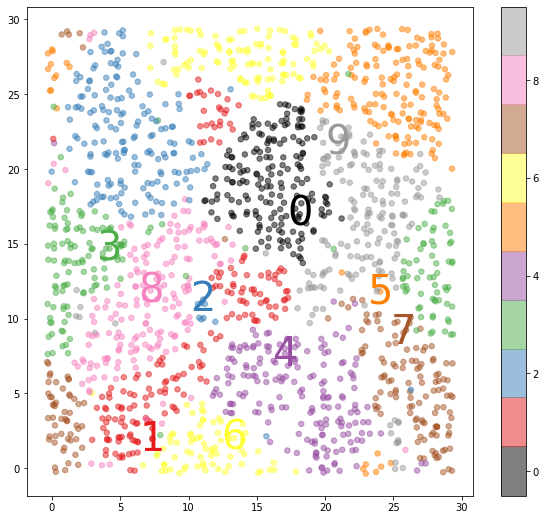

In [817]:
#plt.scatter(pts_[:,0], pts_[:,1], alpha=0.0,s=50,cmap='viridis')
plt.scatter(pts_[:,0], pts_[:,1], c=num, alpha=0.5,s=30,cmap=cols)
plt.colorbar()
plt.clim(-0.5,9.5)
L = []
for i in range(len(pts)):
    d = num[i]
    if not d in L:
        plt.text(pts_[i,0], pts_[i,1],d, va='center',ha='center',fontsize=40,c=cols(d))
        L.append(d)
        if len(L) == 10:
            break
plt.savefig('digits.png',dpi=150, bbox_inches='tight')